# Packages used

In [69]:
!conda list
!which python
!python --version
!jupyter kernelspec list

# packages in environment at /Users/douglas/anaconda3/envs/jupyter_venv:
#
# Name                    Version                   Build  Channel
adjusttext                1.2.0              pyhd8ed1ab_0    conda-forge
anyio                     4.2.0           py312hecd8cb5_0  
appnope                   0.1.3           py312hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py312h6c40b1e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
async-lru                 2.0.4           py312hecd8cb5_0  
attrs                     23.1.0          py312hecd8cb5_0  
babel                     2.11.0          py312hecd8cb5_0  
beautifulsoup4            4.12.3          py312hecd8cb5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
bottleneck                1.3.7           py312h32608ca_0  
brotli                    1.0.9                h6c40b1e_8  
br

# Change output size to fit screen

In [8]:
# Set display options for the entire session
# Set display options to 1000
pd.set_option('display.max_rows', 1000)  # Show up to 1000 rows
pd.set_option('display.max_columns', 1000)  # Show up to 1000 columns
pd.set_option('display.width', 1000)  # Set width to 1000 characters
pd.set_option('display.max_colwidth', 1000)  # Set max column width to 1000 characters


# Data
Input: nutritech_otherdata.xlsx, flx_df files for each group (e.g., flx_df_W5D2T0_.csv)

Output: pca_analysis_significant_results.csv, pca_analysis_results_multiple_files.csv

# Function for clustering groups then kruskal wallis,with averages


In [5]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_pca_kmeans_vs_median(file_ID, n_components_pca, clusters_to_use, pc_x, pc_y, variable_to_compare, method='kmeans'):
    # Load the data
    csv_file = f'{file_ID}.csv'  # File name of the dataset
    pw_flx1 = pd.read_csv(csv_file)
    file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
    xls = pd.ExcelFile(file_path)
    df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

    # Extract the participant IDs from NutriTech data
    nutritech_ids = df_week5_before['name'].tolist()
    pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

    # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
    mapping = {}
    for nt_id in nutritech_ids:
        if nt_id in pw_flx1_ids.values:
            matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
            mapping[nt_id] = matched_column

    # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
    pca_labels = []
    nutritech_labels = []
    for column in pw_flx1.columns:
        matched_id = next((key for key, value in mapping.items() if value == column), None)
        if matched_id:
            label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
            pca_labels.append(label)
            nutritech_labels.append(matched_id)
        else:
            pca_labels.append(np.nan)  # Handle missing data
            nutritech_labels.append('Unknown')

    pca_labels = np.array(pca_labels)
    finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
    norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
    cmap = plt.cm.viridis
    colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

    # Step 2: Perform PCA
    pca = PCA(n_components=n_components_pca)
    pcaData = pca.fit_transform(pw_flx1.T)
    print(pca.explained_variance_ratio_)

    # Choose the method: 'kmeans' or 'median_split'
    if method == 'kmeans':
        # Step 3a: Perform K-Means Clustering
        kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

        # Step 4a: Visualize PCA with K-Means Clusters and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for i in range(clusters_to_use):
            cluster_indices = clusters == i
            plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
            for j in np.where(cluster_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5a: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_clusters = []
        cluster_means = []
        cluster_medians = []
        for i in range(clusters_to_use):
            cluster_values = pca_labels[clusters == i]
            cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
            if len(cluster_values) > 0:
                valid_clusters.append(cluster_values)
                cluster_means.append(np.mean(cluster_values))
                cluster_medians.append(np.median(cluster_values))

        if len(valid_clusters) > 1:
            kruskal_results = kruskal(*valid_clusters)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (K-Means): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid clusters for Kruskal-Wallis test for {variable_to_compare} (K-Means).")

    elif method == 'median_split':
        # Step 3b: Group by Median Split
        median_value = np.nanmedian(pca_labels)  # Calculate the median of the variable
        group_labels = np.array(['Bottom Half' if val <= median_value else 'Top Half' for val in pca_labels])

        # Step 4b: Visualize PCA with Median Split Groups and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for group in ['Bottom Half', 'Top Half']:
            group_indices = group_labels == group
            plt.scatter(pcaData[group_indices, pc_x], pcaData[group_indices, pc_y], label=group, alpha=0.7)
            for j in np.where(group_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'Median Split on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5b: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_groups = []
        group_means = []
        group_medians = []
        for group in ['Bottom Half', 'Top Half']:
            group_values = pca_labels[group_labels == group]
            group_values = group_values[~np.isnan(group_values)]  # Remove NaN values
            if len(group_values) > 0:
                valid_groups.append(group_values)
                group_means.append(np.mean(group_values))
                group_medians.append(np.median(group_values))

        if len(valid_groups) > 1:
            kruskal_results = kruskal(*valid_groups)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (Median Split): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid groups for Kruskal-Wallis test for {variable_to_compare} (Median Split).")

    else:
        print("Invalid method. Choose 'kmeans' or 'median_split'.")

    # Step 6: Print Group/Cluster Assignments and Statistics for Verification
    if method == 'kmeans':
        assignment_data = pd.DataFrame({
            'NutriTech ID': nutritech_labels,
            'Cluster': clusters,
            f'{variable_to_compare}': pca_labels
        })
        print(f"\nAssignments and {variable_to_compare} Values (K-Means):")
        print(assignment_data.sort_values(by='Cluster'))

        # Print mean and median for each cluster
        for i in range(clusters_to_use):
            print(f"Cluster {i+1} - Mean: {cluster_means[i]}, Median: {cluster_medians[i]}")

    elif method == 'median_split':
        assignment_data = pd.DataFrame({
            'NutriTech ID': nutritech_labels,
            'Group': group_labels,
            f'{variable_to_compare}': pca_labels
        })
        print(f"\nAssignments and {variable_to_compare} Values (Median Split):")
        print(assignment_data.sort_values(by='Group'))

        # Print mean and median for each group
        for i, group in enumerate(['Bottom Half', 'Top Half']):
            print(f"{group} - Mean: {group_means[i]}, Median: {group_medians[i]}")


# Function 2 with multiple parameters + table + plots option

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_multiple_files_and_variables(file_IDs, n_components_pca, clusters_to_use, pc_x, pc_y, variables_to_compare, method='kmeans', show_plots=True):
    # Initialize a DataFrame to store all results
    all_results = []

    # Loop through each file_ID
    for file_ID in file_IDs:
        # Loop through each variable to compare
        for variable_to_compare in variables_to_compare:
            print(f"Analyzing {variable_to_compare} in {file_ID}...")

            # Load the data
            csv_file = f'{file_ID}.csv'  # File name of the dataset
            pw_flx1 = pd.read_csv(csv_file)
            file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
            xls = pd.ExcelFile(file_path)
            df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

            # Extract the participant IDs from NutriTech data
            nutritech_ids = df_week5_before['name'].tolist()
            pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

            # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
            mapping = {}
            for nt_id in nutritech_ids:
                if nt_id in pw_flx1_ids.values:
                    matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                    mapping[nt_id] = matched_column

            # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
            pca_labels = []
            nutritech_labels = []
            for column in pw_flx1.columns:
                matched_id = next((key for key, value in mapping.items() if value == column), None)
                if matched_id:
                    label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                    pca_labels.append(label)
                    nutritech_labels.append(matched_id)
                else:
                    pca_labels.append(np.nan)  # Handle missing data
                    nutritech_labels.append('Unknown')

            pca_labels = np.array(pca_labels)
            finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
            norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
            cmap = plt.cm.viridis
            colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

            # Step 2: Perform PCA
            pca = PCA(n_components=n_components_pca)
            pcaData = pca.fit_transform(pw_flx1.T)
            explained_variance_ratio = pca.explained_variance_ratio_

            # Choose the method: 'kmeans' or 'median_split'
            if method == 'kmeans':
                # Step 3a: Perform K-Means Clustering
                kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
                clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

                # Calculate mean and median for each cluster
                cluster_means = []
                cluster_medians = []
                for i in range(clusters_to_use):
                    cluster_values = pca_labels[clusters == i]
                    cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
                    if len(cluster_values) > 0:
                        cluster_means.append(np.mean(cluster_values))
                        cluster_medians.append(np.median(cluster_values))
                    else:
                        cluster_means.append(np.nan)
                        cluster_medians.append(np.nan)

                # Perform Kruskal-Wallis Test
                valid_clusters = [pca_labels[clusters == i][~np.isnan(pca_labels[clusters == i]) & (pca_labels[clusters == i] > 0)] for i in range(clusters_to_use)]
                if len([vc for vc in valid_clusters if len(vc) > 0]) > 1:
                    kruskal_results = kruskal(*valid_clusters)
                    h_statistic = kruskal_results.statistic
                    p_value = kruskal_results.pvalue
                else:
                    h_statistic = np.nan
                    p_value = np.nan

                # Step 4a: Display the table at the start before plotting
                cluster_data = pd.DataFrame({
                    'File ID': file_ID,
                    'Variable': variable_to_compare,
                    'Cluster': [f'Cluster {i+1}' for i in range(clusters_to_use)],
                    'Mean': cluster_means,
                    'Median': cluster_medians,
                    'H-Statistic': h_statistic,
                    'P-Value': p_value
                })
                print(f"\n{file_ID} - {variable_to_compare} Results:")
                print(cluster_data)

                # Plot PCA with K-Means Clusters and NutriTech IDs
                if show_plots:
                    plt.figure(figsize=(10, 8))
                    for i in range(clusters_to_use):
                        cluster_indices = clusters == i
                        plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
                        for j in np.where(cluster_indices)[0]:
                            plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

                    plt.xlabel(f'PC{pc_x+1}: {explained_variance_ratio[pc_x]*100:.2f}% variance')
                    plt.ylabel(f'PC{pc_y+1}: {explained_variance_ratio[pc_y]*100:.2f}% variance')
                    plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
                    plt.legend()
                    plt.grid(True)
                    plt.show()

            elif method == 'median_split':
                # Step 3b: Group by Median Split
                median_value = np.nanmedian(pca_labels)
                group_labels = np.array(['Bottom Half' if val <= median_value else 'Top Half' for val in pca_labels])

                # Calculate mean and median for each group
                group_means = []
                group_medians = []
                for group in ['Bottom Half', 'Top Half']:
                    group_values = pca_labels[group_labels == group]
                    group_values = group_values[~np.isnan(group_values)]
                    if len(group_values) > 0:
                        group_means.append(np.mean(group_values))
                        group_medians.append(np.median(group_values))
                    else:
                        group_means.append(np.nan)
                        group_medians.append(np.nan)

                # Perform Kruskal-Wallis Test
                valid_groups = [pca_labels[group_labels == group][~np.isnan(pca_labels[group_labels == group])] for group in ['Bottom Half', 'Top Half']]
                if len([vg for vg in valid_groups if len(vg) > 0]) > 1:
                    kruskal_results = kruskal(*valid_groups)
                    h_statistic = kruskal_results.statistic
                    p_value = kruskal_results.pvalue
                else:
                    h_statistic = np.nan
                    p_value = np.nan

                # Step 4b: Display the table at the start before plotting
                group_data = pd.DataFrame({
                    'File ID': file_ID,
                    'Variable': variable_to_compare,
                    'Group': ['Bottom Half', 'Top Half'],
                    'Mean': group_means,
                    'Median': group_medians,
                    'H-Statistic': h_statistic,
                    'P-Value': p_value
                })
                print(f"\n{file_ID} - {variable_to_compare} Results:")
                print(group_data)

                # Plot PCA with Median Split Groups and NutriTech IDs
                if show_plots:
                    plt.figure(figsize=(10, 8))
                    for group in ['Bottom Half', 'Top Half']:
                        group_indices = group_labels == group
                        plt.scatter(pcaData[group_indices, pc_x], pcaData[group_indices, pc_y], label=group, alpha=0.7)
                        for j in np.where(group_indices)[0]:
                            plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

                    plt.xlabel(f'PC{pc_x+1}: {explained_variance_ratio[pc_x]*100:.2f}% variance')
                    plt.ylabel(f'PC{pc_y+1}: {explained_variance_ratio[pc_y]*100:.2f}% variance')
                    plt.title(f'Median Split on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
                    plt.legend()
                    plt.grid(True)
                    plt.show()

            else:
                print("Invalid method. Choose 'kmeans' or 'median_split'.")
                continue

            # Save results for this variable and file_ID
            for i in range(clusters_to_use):
                all_results.append({
                    'File ID': file_ID,
                    'Variable': variable_to_compare,
                    'Method': method,
                    'Cluster': f'Cluster {i+1}' if method == 'kmeans' else ['Bottom Half', 'Top Half'][i],
                    'Mean': cluster_means[i] if method == 'kmeans' else group_means[i],
                    'Median': cluster_medians[i] if method == 'kmeans' else group_medians[i],
                    'H-Statistic': h_statistic,
                    'P-Value': p_value
                })

    # Convert all results into a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df


In [63]:
# Example usage
'''Index(['name', 'Age', 'Gender', 'Body weight ', 'Body height ', 'BMI ',
       'Start group', 'fasting glucose', '2hr glucose', 'fasting insulin',
       'fasting triglyceride', 'HOMA-IR', 'Matsuda', 'IGI', 'CRP-D1',
       'E-Selectin-D1', 'IL18-D1', 'IL1b-D1', 'TNF-alpha-D1', 'VCAM-1-D1',
       'adiponectin-D1','IL1-AVG', 'IL6-AVG', 'IL10-AVG', 'IL8-AVG', 'MCP1-AVG', 'ICAM1-AVG']'''

file_IDs = [ 'W5D2T0_', 'W5D2T120_', 'W5D3T0_','W5D3T120_','W5D3T240_']  # Add more file IDs as needed
variables_to_compare = ['BMI ', 'Age', 'Body weight ', 
       'fasting glucose', '2hr glucose', 'fasting insulin',
       'fasting triglyceride', 'HOMA-IR', 'Matsuda', 'IGI', 'CRP-D1',
       'E-Selectin-D1', 'IL18-D1', 'IL1b-D1', 'TNF-alpha-D1', 'VCAM-1-D1',
       'adiponectin-D1','IL1-AVG', 'IL6-AVG', 'IL10-AVG', 'IL8-AVG', 'MCP1-AVG', 'ICAM1-AVG']  # Add more variables as needed
results_df = analyze_multiple_files_and_variables(
    file_IDs=file_IDs,
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, # 0 based, +1
    pc_y=1, # 0 based, +1
    variables_to_compare=variables_to_compare,
    method='kmeans',  # Can be 'kmeans' or 'median_split'
    show_plots=False  # Set to True to view plots, False to skip them
)

# Save the results to a CSV file
results_df.to_csv('pca_analysis_results_multiple_files.csv', index=False)

# Display the results
print(results_df)

Analyzing BMI  in W5D2T0_...

W5D2T0_ - BMI  Results:
   File ID Variable    Cluster       Mean     Median  H-Statistic   P-Value
0  W5D2T0_     BMI   Cluster 1  28.908525  29.291951     0.752856  0.385574
1  W5D2T0_     BMI   Cluster 2  29.412829  28.664143     0.752856  0.385574
Analyzing Age in W5D2T0_...

W5D2T0_ - Age Results:
   File ID Variable    Cluster       Mean  Median  H-Statistic   P-Value
0  W5D2T0_      Age  Cluster 1  58.606061    59.0     0.969517  0.324801
1  W5D2T0_      Age  Cluster 2  59.931034    61.0     0.969517  0.324801
Analyzing Body weight  in W5D2T0_...

W5D2T0_ - Body weight  Results:
   File ID      Variable    Cluster       Mean  Median  H-Statistic   P-Value
0  W5D2T0_  Body weight   Cluster 1  84.639394    85.1     0.064492  0.799532
1  W5D2T0_  Body weight   Cluster 2  83.634483    82.0     0.064492  0.799532
Analyzing fasting glucose in W5D2T0_...

W5D2T0_ - fasting glucose Results:
   File ID         Variable    Cluster      Mean  Median  H-Statist

# Function 3 , read csv file for significant results, option to show their plots

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import LogNorm

def analyze_significant_results_from_csv(csv_file, significance_level=0.05, show_plots=True):
    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Filter for significant results based on p-value
    significant_results = results_df[results_df['P-Value'] <= significance_level]

    # Display the significant results table
    print("Significant Results (P-Value <= {}):".format(significance_level))
    print(significant_results)

    # Initialize a list to store plot details
    plot_details = []

    # Loop through each significant result and plot
    for _, row in significant_results.iterrows():
        file_ID = row['File ID']
        variable_to_compare = row['Variable']
        cluster = row['Cluster']
        method = row['Method']
        mean = row['Mean']
        median = row['Median']
        h_statistic = row['H-Statistic']
        p_value = row['P-Value']

        if show_plots:
            print(f"Plotting {variable_to_compare} for {file_ID} with {cluster}...")

        # Load the data again based on file_ID
        csv_file = f'{file_ID}.csv'  # File name of the dataset
        pw_flx1 = pd.read_csv(csv_file)
        file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
        xls = pd.ExcelFile(file_path)
        df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

        # Extract the participant IDs from NutriTech data
        nutritech_ids = df_week5_before['name'].tolist()
        pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

        # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
        mapping = {}
        for nt_id in nutritech_ids:
            if nt_id in pw_flx1_ids.values:
                matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
                mapping[nt_id] = matched_column

        # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
        pca_labels = []
        nutritech_labels = []
        for column in pw_flx1.columns:
            matched_id = next((key for key, value in mapping.items() if value == column), None)
            if matched_id:
                label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
                pca_labels.append(label)
                nutritech_labels.append(matched_id)
            else:
                pca_labels.append(np.nan)  # Handle missing data
                nutritech_labels.append('Unknown')

        pca_labels = np.array(pca_labels)
        finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
        norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
        cmap = plt.cm.viridis
        colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

        # Perform PCA
        pca = PCA(n_components=4)
        pcaData = pca.fit_transform(pw_flx1.T)
        explained_variance_ratio = pca.explained_variance_ratio_

        # Re-run K-Means clustering for plotting
        kmeans = KMeans(n_clusters=2, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [0, 1]])  # Re-using PC1 vs PC2

        # Plot PCA with K-Means Clusters and NutriTech IDs
        if show_plots:
            plt.figure(figsize=(10, 8))
            for i in range(2):
                cluster_indices = clusters == i
                plt.scatter(pcaData[cluster_indices, 0], pcaData[cluster_indices, 1], label=f'Cluster {i+1}', alpha=0.7)
                for j in np.where(cluster_indices)[0]:
                    plt.text(pcaData[j, 0], pcaData[j, 1], nutritech_labels[j], fontsize=8, ha='right')

            plt.xlabel(f'PC1: {explained_variance_ratio[0]*100:.2f}% variance')
            plt.ylabel(f'PC2: {explained_variance_ratio[1]*100:.2f}% variance')
            plt.title(f'K-Means Clustering on {variable_to_compare} for {file_ID} (PC1 vs PC2)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Append the details of the plot to plot_details
        plot_details.append({
            'File ID': file_ID,
            'Variable': variable_to_compare,
            'Method': method,
            'Cluster': cluster,
            'Mean': mean,
            'Median': median,
            'H-Statistic': h_statistic,
            'P-Value': p_value
        })

    # Convert plot details to a DataFrame for record-keeping
    plots_df = pd.DataFrame(plot_details)
    return plots_df

In [9]:
# Example usage
significant_results_df = analyze_significant_results_from_csv(
    csv_file='pca_analysis_results_multiple_files.csv',  # Path to the previously saved CSV
    significance_level=0.05,  # Set significance threshold
    show_plots=False  # Set to True to generate plots
)

# Display the results
print(significant_results_df)

significant_results_df.to_csv('pca_analysis_significant_results.csv', index=False)


Significant Results (P-Value <= 0.05):
       File ID              Variable  Method    Cluster        Mean      Median  H-Statistic   P-Value
12     W5D2T0_  fasting triglyceride  kmeans  Cluster 1    1.157224    1.030000     4.128223  0.042174
13     W5D2T0_  fasting triglyceride  kmeans  Cluster 2    1.419310    1.200000     4.128223  0.042174
20     W5D2T0_                CRP-D1  kmeans  Cluster 1  782.639389  503.515526     5.785988  0.016154
21     W5D2T0_                CRP-D1  kmeans  Cluster 2  679.260428  225.793610     5.785988  0.016154
42     W5D2T0_              MCP1-AVG  kmeans  Cluster 1  203.939877  153.556805     3.857620  0.049521
43     W5D2T0_              MCP1-AVG  kmeans  Cluster 2  173.035184  171.031818     3.857620  0.049521
70   W5D2T120_               IL18-D1  kmeans  Cluster 1  275.443734  251.087205     4.494890  0.033996
71   W5D2T120_               IL18-D1  kmeans  Cluster 2  218.941931  202.654606     4.494890  0.033996
182  W5D3T120_             ICAM1-A

Significant Results (P-Value <= 0.05):
       File ID              Variable  Method    Cluster        Mean      Median  H-Statistic   P-Value
12     W5D2T0_  fasting triglyceride  kmeans  Cluster 1    1.157224    1.030000     4.128223  0.042174
13     W5D2T0_  fasting triglyceride  kmeans  Cluster 2    1.419310    1.200000     4.128223  0.042174
20     W5D2T0_                CRP-D1  kmeans  Cluster 1  782.639389  503.515526     5.785988  0.016154
21     W5D2T0_                CRP-D1  kmeans  Cluster 2  679.260428  225.793610     5.785988  0.016154
42     W5D2T0_              MCP1-AVG  kmeans  Cluster 1  203.939877  153.556805     3.857620  0.049521
43     W5D2T0_              MCP1-AVG  kmeans  Cluster 2  173.035184  171.031818     3.857620  0.049521
70   W5D2T120_               IL18-D1  kmeans  Cluster 1  275.443734  251.087205     4.494890  0.033996
71   W5D2T120_               IL18-D1  kmeans  Cluster 2  218.941931  202.654606     4.494890  0.033996
182  W5D3T120_             ICAM1-A

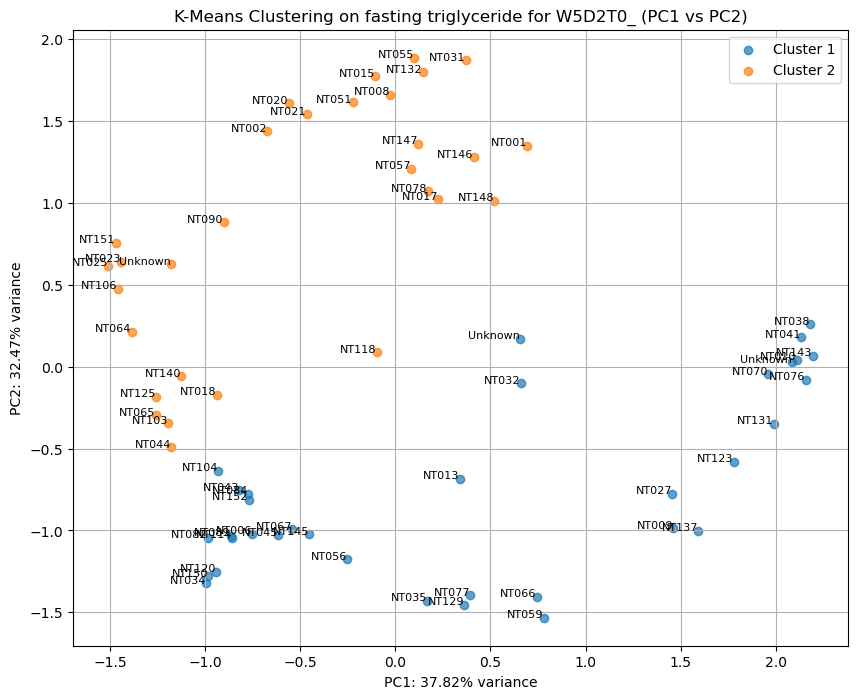

Plotting fasting triglyceride for W5D2T0_ with Cluster 2...


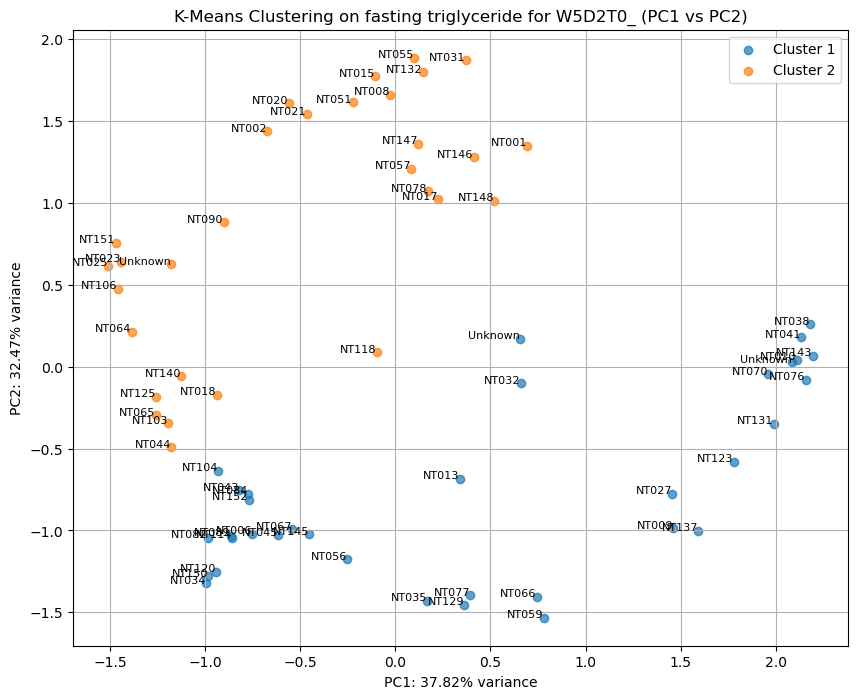

Plotting CRP-D1 for W5D2T0_ with Cluster 1...


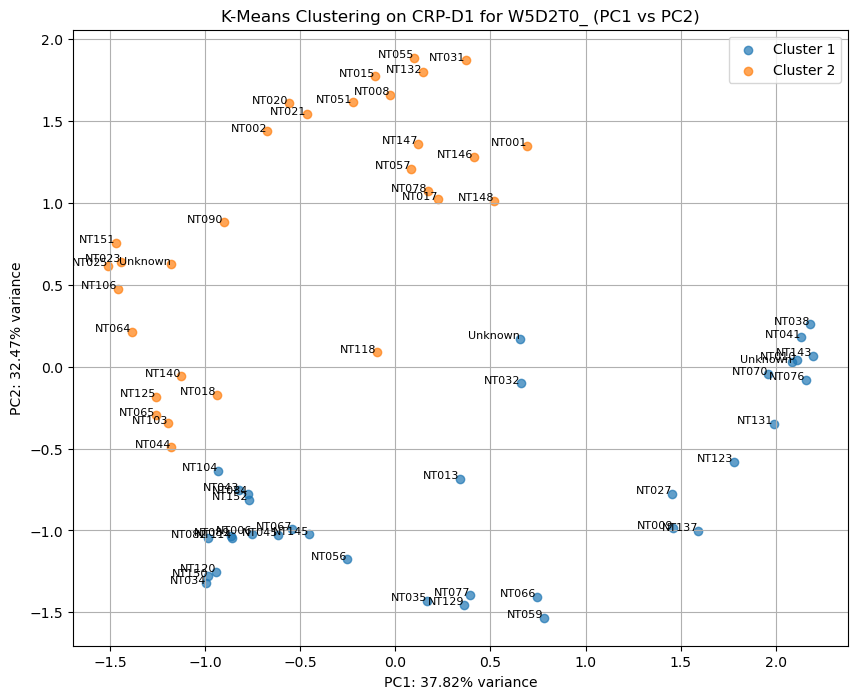

Plotting CRP-D1 for W5D2T0_ with Cluster 2...


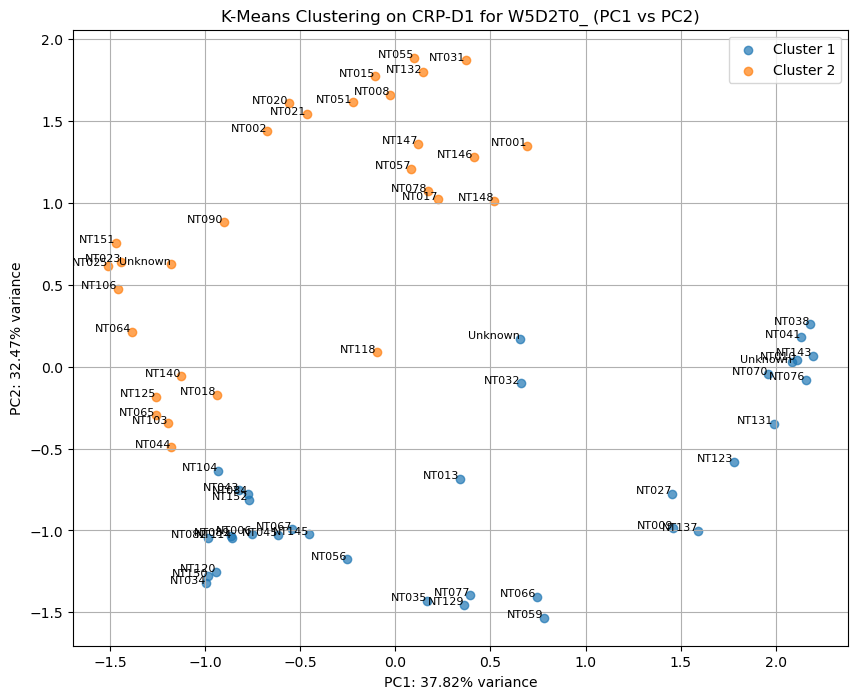

Plotting MCP1-AVG for W5D2T0_ with Cluster 1...


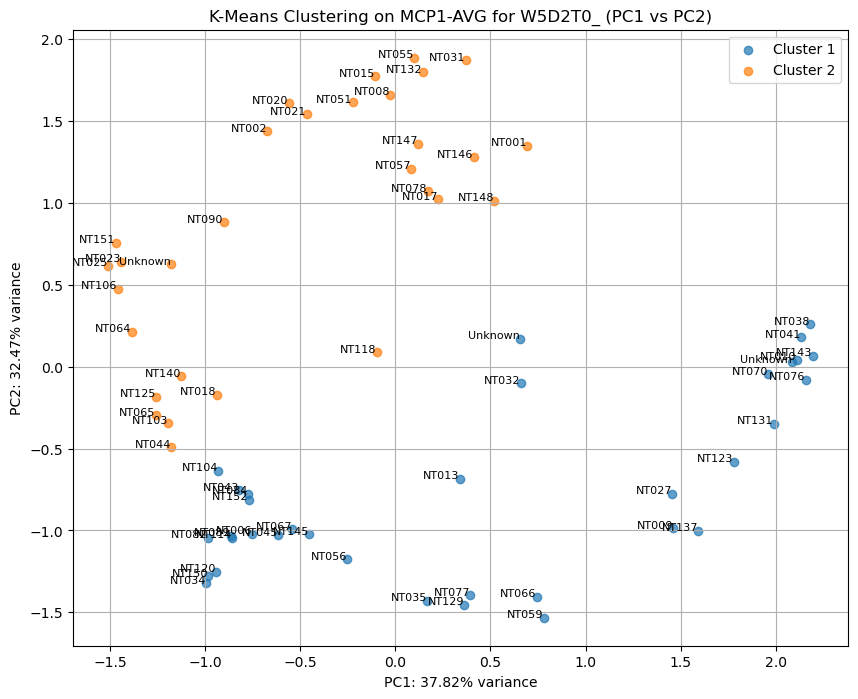

Plotting MCP1-AVG for W5D2T0_ with Cluster 2...


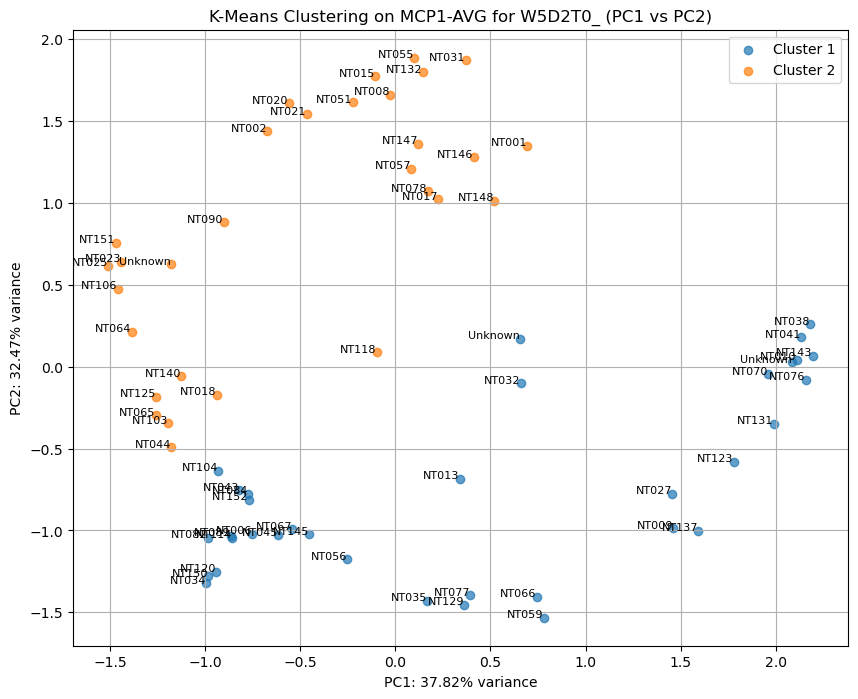

Plotting IL18-D1 for W5D2T120_ with Cluster 1...


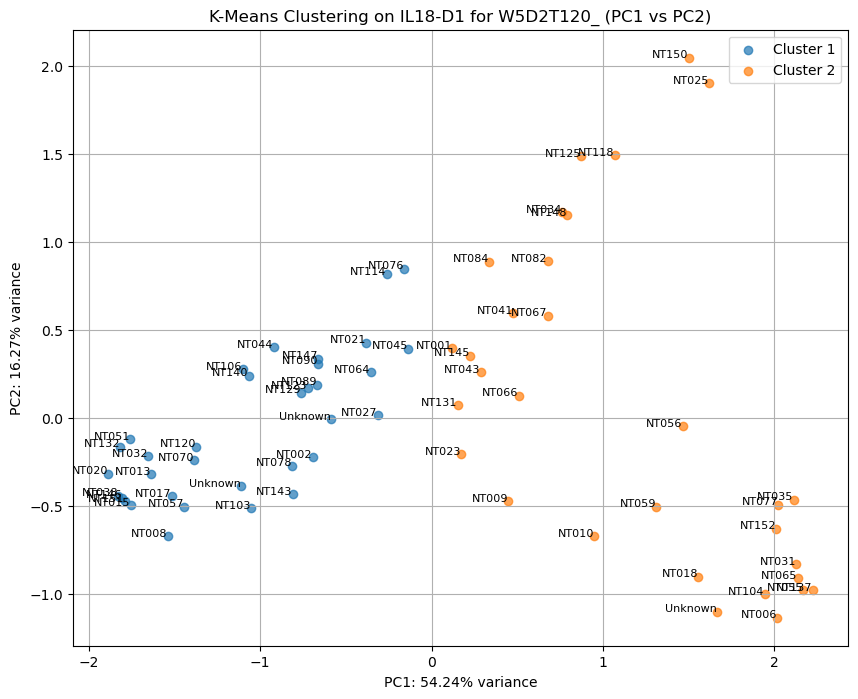

Plotting IL18-D1 for W5D2T120_ with Cluster 2...


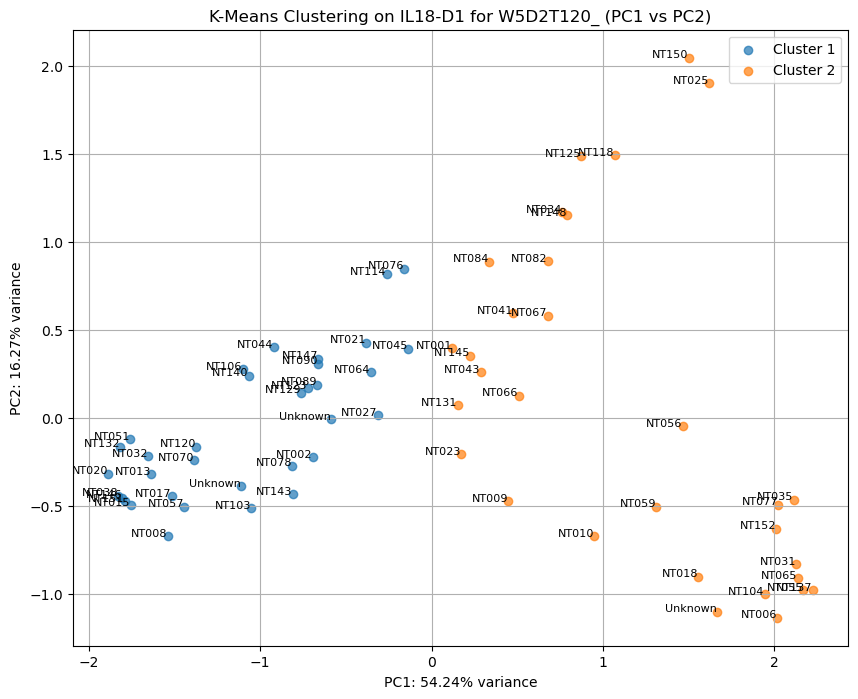

Plotting ICAM1-AVG for W5D3T120_ with Cluster 1...


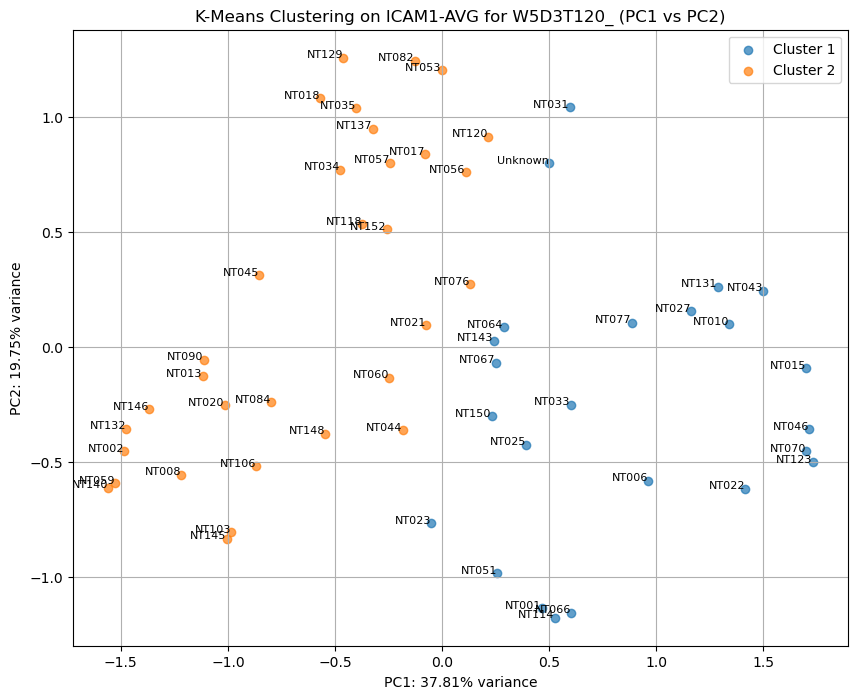

Plotting ICAM1-AVG for W5D3T120_ with Cluster 2...


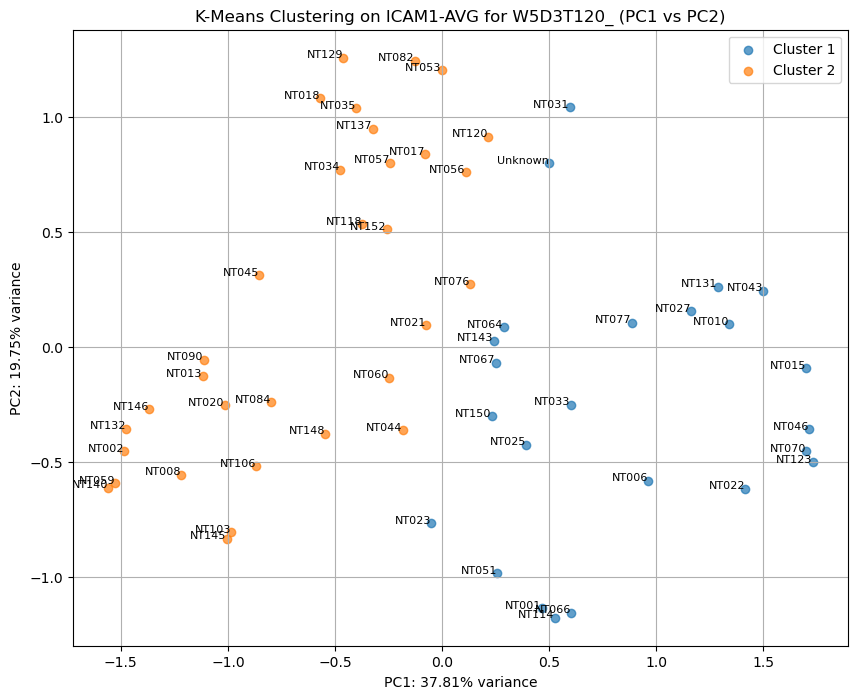

Plotting CRP-D1 for W5D3T240_ with Cluster 1...


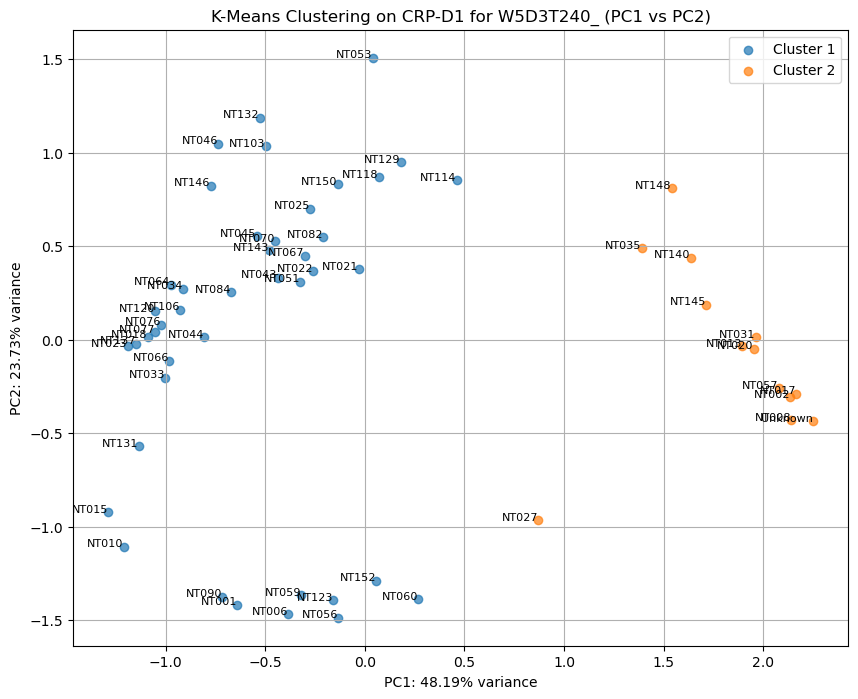

Plotting CRP-D1 for W5D3T240_ with Cluster 2...


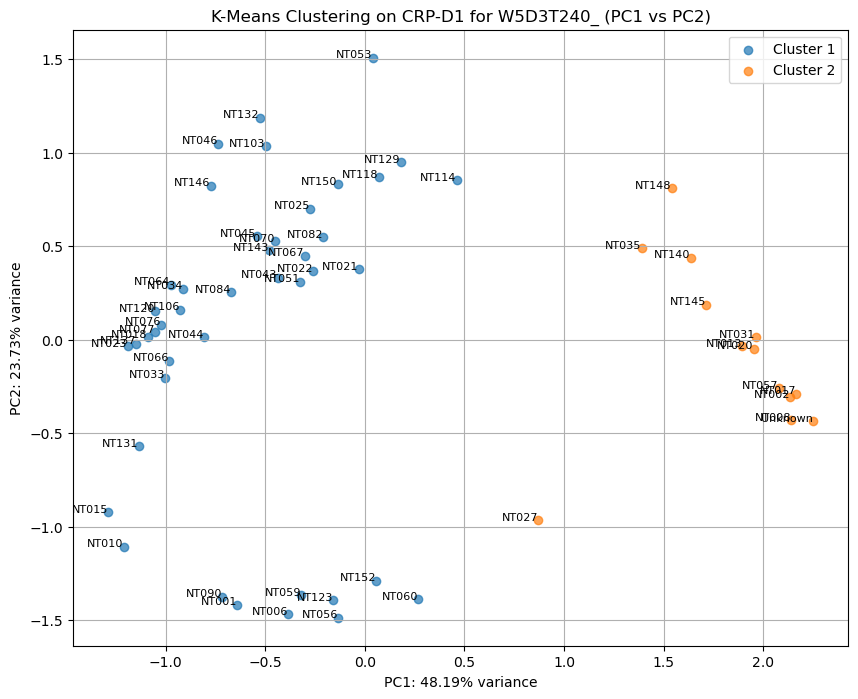

Plotting IL18-D1 for W5D3T240_ with Cluster 1...


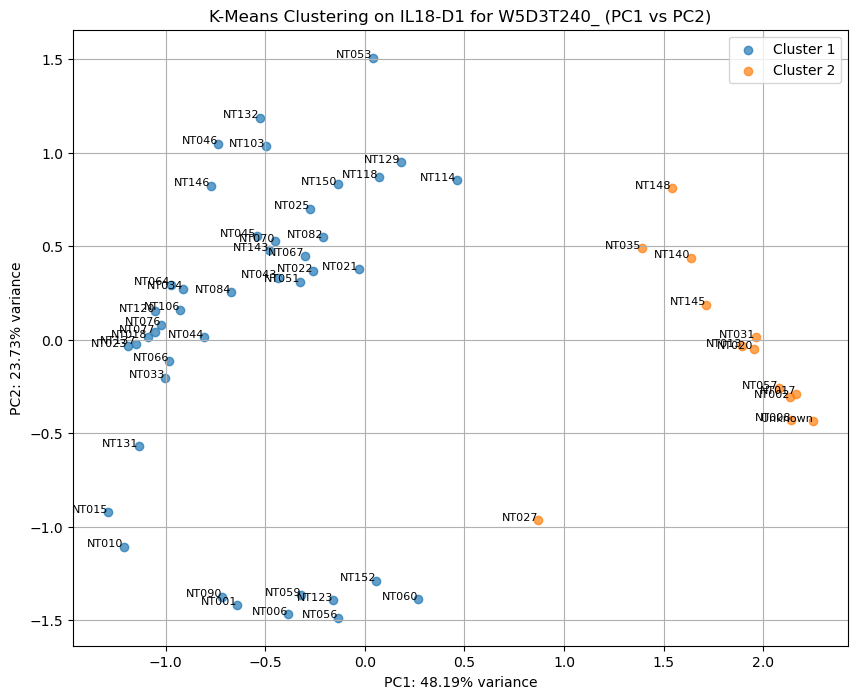

Plotting IL18-D1 for W5D3T240_ with Cluster 2...


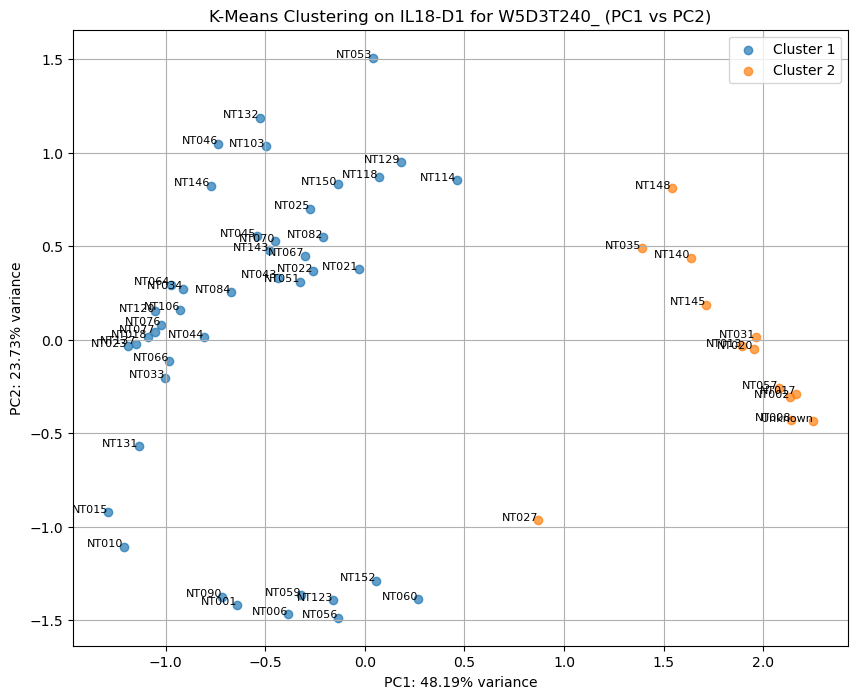

      File ID              Variable  Method    Cluster        Mean      Median  H-Statistic   P-Value
0     W5D2T0_  fasting triglyceride  kmeans  Cluster 1    1.157224    1.030000     4.128223  0.042174
1     W5D2T0_  fasting triglyceride  kmeans  Cluster 2    1.419310    1.200000     4.128223  0.042174
2     W5D2T0_                CRP-D1  kmeans  Cluster 1  782.639389  503.515526     5.785988  0.016154
3     W5D2T0_                CRP-D1  kmeans  Cluster 2  679.260428  225.793610     5.785988  0.016154
4     W5D2T0_              MCP1-AVG  kmeans  Cluster 1  203.939877  153.556805     3.857620  0.049521
5     W5D2T0_              MCP1-AVG  kmeans  Cluster 2  173.035184  171.031818     3.857620  0.049521
6   W5D2T120_               IL18-D1  kmeans  Cluster 1  275.443734  251.087205     4.494890  0.033996
7   W5D2T120_               IL18-D1  kmeans  Cluster 2  218.941931  202.654606     4.494890  0.033996
8   W5D3T120_             ICAM1-AVG  kmeans  Cluster 1  218.399803  218.624085    

In [10]:
# Example usage
significant_results_df = analyze_significant_results_from_csv(
    csv_file='pca_analysis_results_multiple_files.csv',  # Path to the previously saved CSV
    significance_level=0.05,  # Set significance threshold
    show_plots=True  # Set to True to generate plots
)

# Display the results
print(significant_results_df)

significant_results_df.to_csv('pca_analysis_significant_results.csv', index=False)
